In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")

# Common imports
import numpy as np
import os
from pathlib import Path

# To make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes',  labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [ ]:
### BASIC RNNs ###

In [ ]:
def generate_time_series(batch_size, n_steps):
    """
    Generate `batch_size` univariate time series, each of length `n_steps`
    
    Returns a NumPy array of shape [batch size, time steps, 1],
    where each series is the sum of two sine waves of fixed amplitudes
    but random frequencies and phases, plus a bit of noise
    """
    
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series  = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))  # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)    # + noise
    
    return series[..., np.newaxis].astype(np.float32)

In [ ]:
np.random.seed(42)

# Generate time series
n_steps = 50
series = generate_time_series(10000, n_steps + 1) # generate `n_steps + 1` (51) time steps

# Split the data
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test,  y_test  = series[9000:, :n_steps], series[9000:, -1]

In [ ]:
# When dealing with time series (and other types of sequences such as sentences),
# the input features are generally represented as 3D arrays of shape [batch size, time steps, dimensionality],
# where dimensionality is 1 for univariate time series and more for multivariate time series.

In [ ]:
X_train.shape

(7000, 50, 1)

In [ ]:
y_train.shape

(7000, 1)

Saving figure time_series_plot


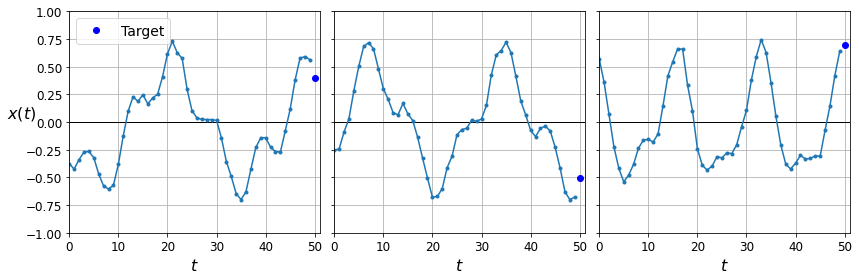

In [ ]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

# Let's plot 3 time series from the `validation` set
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
save_fig("time_series_plot")
plt.show()

In [ ]:
## BASELINE METRICS ##

In [ ]:
X_valid[:, -1] # values for the *50th* time step (for each time series)

array([[-0.24104503],
       [-0.0664911 ],
       [-0.34863472],
       ...,
       [ 0.38053507],
       [ 0.5468222 ],
       [-0.3460202 ]], dtype=float32)

In [ ]:
y_valid # values for the *51th* time step (for each time series)

array([[ 0.4000832 ],
       [-0.50259125],
       [ 0.69304645],
       ...,
       [-0.25712416],
       [-0.2791788 ],
       [ 0.6290542 ]], dtype=float32)

In [ ]:
# Naive predictions (just predict the last observed value - which is already in the dataset)
# This methods says that the next value in the time series is equal to the last observed value
# Last value from the dataset <=> Next value (predicted one)

## `Naive forecasting` says that the time series will remain constant for the next time step ## 

y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

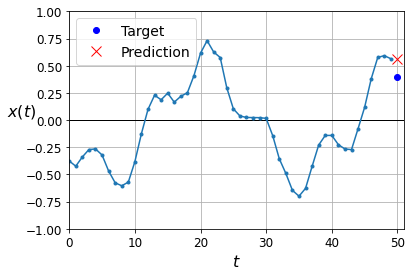

In [ ]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [ ]:
# Linear predictions

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 2ms/step - loss: 0.1001 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0062

In [ ]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 6ms/step - loss: 0.2185


0.21850353479385376

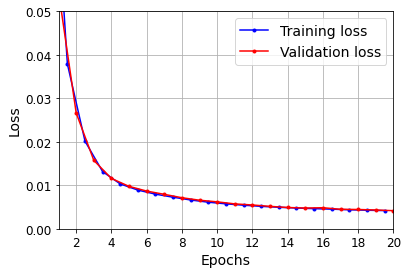

In [ ]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

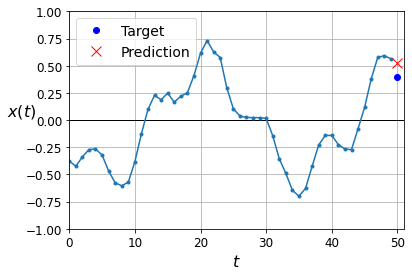

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [ ]:
## IMPLEMENTING A SIMPLE RNN ##

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 9ms/step - loss: 0.0967 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0369 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0253 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0198 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0166 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0116 - val_loss: 0.011

In [ ]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0109


0.010881561785936356

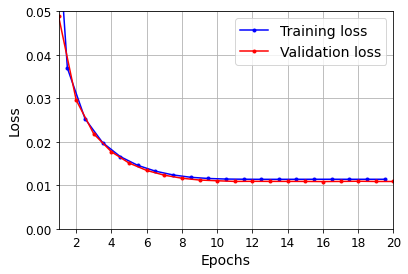

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
# Apparently our simple RNN was too simple to get good performance.
# So let’s try to add more recurrent layers!

In [ ]:
X_train.shape
# 7000 time series
# 50   time steps (points - OX axis)
# 1    univariate time series

(7000, 50, 1)

In [ ]:
## DEEP RNNs ##

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 9s 30ms/step - loss: 0.0492 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 8s 35ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0035 - val_lo

In [ ]:
# Make sure to set `return_sequences=True` for all recurrent layers
# (except the last one, if you only care about the last output prediction).
# If you don’t, they will output a 2D array (containing only the output of
# the last time step) instead of a 3D array (containing outputs for all
# time steps), and the next recurrent layer will complain that you are
# not feeding it sequences in the expected 3D format.

In [ ]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 12ms/step - loss: 0.0029


0.002910564886406064

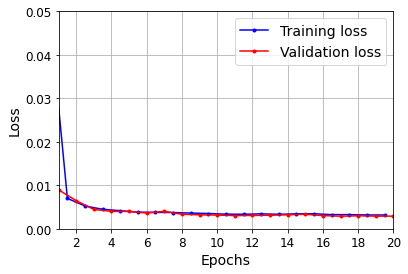

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

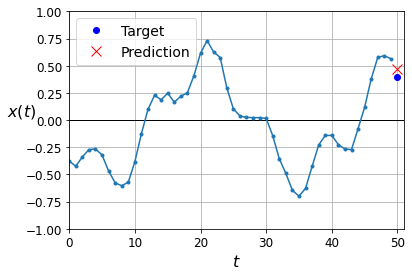

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [ ]:
# Make the second `SimpleRNN` layer return only the last output (add a Dense layer at the end)
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 6s 20ms/step - loss: 0.0232 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0030 - val_lo

In [ ]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 6ms/step - loss: 0.0026


0.002623623237013817

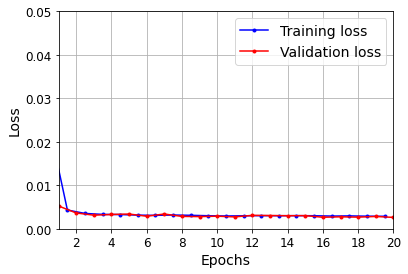

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

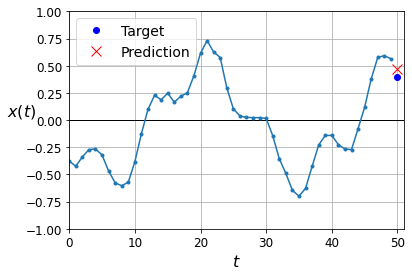

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [ ]:
## FORECASTING SEVERAL TIME STEPS AHEAD ##

In [ ]:
# The first option is to use the model we already trained, make it predict the next value,
# then add that value to the inputs (acting as if this predicted value had actually occur‐
# red), and use the model again to predict the following value, and so on, as in the following code

In [ ]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    # Add the prediction to the time series values
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [ ]:
Y_pred.shape

(1, 10, 1)

Saving figure forecast_ahead_plot


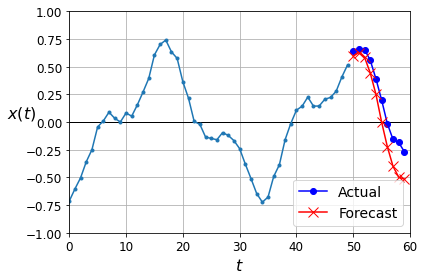

In [ ]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead   = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

In [ ]:
# The second option is to train an RNN to predict all 10 next values at once. We can
# still use a sequence-to-vector model, but it will output 10 values instead of 1.
# However, we first need to change the targets to be vectors containing the next 10 values

In [ ]:
np.random.seed(42)

n_steps = 50
series  = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test,  Y_test  = series[9000:, :n_steps], series[9000:, -10:, 0]

In [ ]:
X_train.shape

(7000, 50, 1)

In [ ]:
Y_train.shape # next 10 values

(7000, 50, 10)

In [ ]:
# Now let's create an RNN that predicts all 10 next values at once

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10) # 10 instead of 1
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 6s 21ms/step - loss: 0.0669 - val_loss: 0.0317
Epoch 2/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0265 - val_loss: 0.0200
Epoch 3/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0183 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0155 - val_loss: 0.0144
Epoch 5/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0139 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0128 - val_loss: 0.0112
Epoch 7/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0122 - val_loss: 0.0110
Epoch 8/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0115 - val_loss: 0.0103
Epoch 9/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0110 - val_lo

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

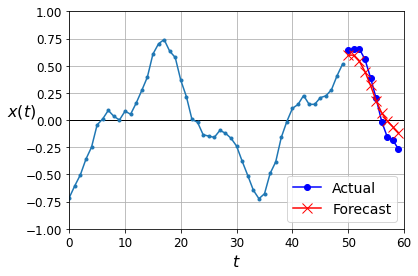

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [ ]:
# Now let's create an RNN that predicts the next 10 steps at each time step.
# That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49,
# it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on,
# and finally it will forecast time steps 50 to 59 at the last time step.
# Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [ ]:
np.random.seed(42)

n_steps = 50
series  = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test  = series[9000:, :n_steps]

Y = np.empty((10000, n_steps, 10)) # each target is a sequence of 10D vectors
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]

Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test  = Y[9000:]

In [ ]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

# All outputs are needed during training, but only the output at the last time step
# is useful for predictions and for evaluation.
# Although we will rely on the MSE over all the outputs for training,
# we will use a custom metric for evaluation, to only compute
# the MSE over the output at the last time step
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 7s 24ms/step - loss: 0.0508 - last_time_step_mse: 0.0400 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324
Epoch 2/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0395 - last_time_step_mse: 0.0283 - val_loss: 0.0363 - val_last_time_step_mse: 0.0260
Epoch 3/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0325 - last_time_step_mse: 0.0214 - val_loss: 0.0368 - val_last_time_step_mse: 0.0279
Epoch 4/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0298 - last_time_step_mse: 0.0188 - val_loss: 0.0273 - val_last_time_step_mse: 0.0155
Epoch 5/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0270 - last_time_step_mse: 0.0149 - val_loss: 0.0266 - val_last_time_step_mse: 0.0163
Epoch 6/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0250 - last_time_step_mse: 0.0123 - val_loss: 0.0248 - val_last_time_step_mse: 0.0122
Epoch 7/20
219/219 [==

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

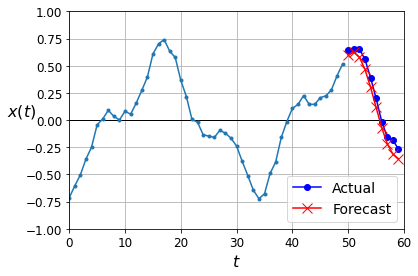

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [ ]:
### UNSTABLE GRADIENTS PROBLEM ###

In [ ]:
## DEEP RNN with LAYER NORMALIZATION ##

In [ ]:
from tensorflow.keras.layers import LayerNormalization

In [ ]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size  = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs] # return new_outputs, new_hidden_states

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 13s 44ms/step - loss: 0.1595 - last_time_step_mse: 0.1549 - val_loss: 0.0711 - val_last_time_step_mse: 0.0646
Epoch 2/20
219/219 [==============================] - 11s 49ms/step - loss: 0.0629 - last_time_step_mse: 0.0550 - val_loss: 0.0569 - val_last_time_step_mse: 0.0492
Epoch 3/20
219/219 [==============================] - 9s 41ms/step - loss: 0.0534 - last_time_step_mse: 0.0451 - val_loss: 0.0495 - val_last_time_step_mse: 0.0404
Epoch 4/20
219/219 [==============================] - 10s 45ms/step - loss: 0.0471 - last_time_step_mse: 0.0381 - val_loss: 0.0458 - val_last_time_step_mse: 0.0378
Epoch 5/20
219/219 [==============================] - 9s 42ms/step - loss: 0.0426 - last_time_step_mse: 0.0330 - val_loss: 0.0408 - val_last_time_step_mse: 0.0314
Epoch 6/20
219/219 [==============================] - 10s 44ms/step - loss: 0.0392 - last_time_step_mse: 0.0288 - val_loss: 0.0374 - val_last_time_step_mse: 0.0258
Epoch 7/20
219/219

In [ ]:
# Similarly, you could create a custom cell to apply dropout between each time step. But
# there’s a simpler way: all recurrent layers (except for keras.layers.RNN) and all cells
# provided by Keras have a dropout hyperparameter and a recurrent_dropout hyper‐
# parameter: the former defines the dropout rate to apply to the inputs (at each time
# step), and the latter defines the dropout rate for the hidden states (also at each time
# step). No need to create a custom cell to apply dropout at each time step in an RNN.

# With these techniques, you can alleviate the unstable gradients problem and train an
# RNN much more efficiently. Now let’s look at how to deal with the short-term mem‐
# ory problem.

In [ ]:
### SHORT-TERM MEMORY PROBLEM ###

In [ ]:
# Imagine Dory the fish trying to translate a long sentence; by the time she’s finished reading it, she has no
# clue how it started. To tackle this problem, various types of cells with long-term
# memory have been introduced. They have proven so successful that the basic cells are
# not used much anymore. Let’s first look at the most popular of these long-term memory cells: the LSTM cell.

In [ ]:
## LSTM cells ##

In [ ]:
# If you consider the LSTM cell as a black box, it can be used very much like a basic cell,
# except it will perform much better; training will converge faster, and it will detect long-term dependencies in the data.
# In Keras, you can simply use the LSTM layer instead of the SimpleRNN layer

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 15s 51ms/step - loss: 0.0760 - last_time_step_mse: 0.0615 - val_loss: 0.0554 - val_last_time_step_mse: 0.0364
Epoch 2/20
219/219 [==============================] - 12s 54ms/step - loss: 0.0480 - last_time_step_mse: 0.0283 - val_loss: 0.0427 - val_last_time_step_mse: 0.0222
Epoch 3/20
219/219 [==============================] - 10s 47ms/step - loss: 0.0391 - last_time_step_mse: 0.0181 - val_loss: 0.0367 - val_last_time_step_mse: 0.0157
Epoch 4/20
219/219 [==============================] - 10s 44ms/step - loss: 0.0350 - last_time_step_mse: 0.0151 - val_loss: 0.0334 - val_last_time_step_mse: 0.0132
Epoch 5/20
219/219 [==============================] - 11s 50ms/step - loss: 0.0325 - last_time_step_mse: 0.0133 - val_loss: 0.0314 - val_last_time_step_mse: 0.0121
Epoch 6/20
219/219 [==============================] - 10s 44ms/step - loss: 0.0308 - last_time_step_mse: 0.0122 - val_loss: 0.0298 - val_last_time_step_mse: 0.0112
Epoch 7/20
219/2

In [ ]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 1s 15ms/step - loss: 0.0238 - last_time_step_mse: 0.0086


[0.023788679391145706, 0.008560794405639172]

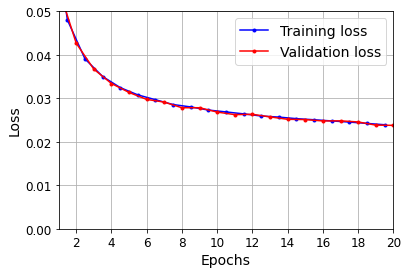

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

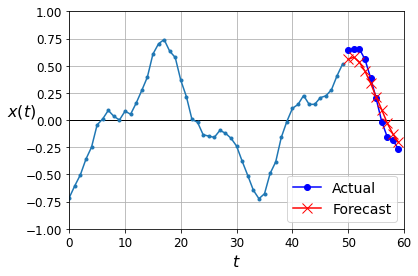

In [ ]:
# LSTM
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [ ]:
## GRUs ##

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

# Just replace the `SimpleRNN` or `LSTM` with `GRU`
model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=5, validation_data=(X_valid, Y_valid))

Epoch 1/5
219/219 [==============================] - 80s 66ms/step - loss: 0.0738 - last_time_step_mse: 0.0655 - val_loss: 0.0538 - val_last_time_step_mse: 0.0450
Epoch 2/5
219/219 [==============================] - 13s 60ms/step - loss: 0.0476 - last_time_step_mse: 0.0367 - val_loss: 0.0441 - val_last_time_step_mse: 0.0326
Epoch 3/5
219/219 [==============================] - 13s 59ms/step - loss: 0.0417 - last_time_step_mse: 0.0301 - val_loss: 0.0390 - val_last_time_step_mse: 0.0275
Epoch 4/5
219/219 [==============================] - 14s 65ms/step - loss: 0.0368 - last_time_step_mse: 0.0243 - val_loss: 0.0339 - val_last_time_step_mse: 0.0202
Epoch 5/5
219/219 [==============================] - 13s 58ms/step - loss: 0.0326 - last_time_step_mse: 0.0180 - val_loss: 0.0312 - val_last_time_step_mse: 0.0164


In [ ]:
## Using 1D Convolutional layers to process sequences ##

In [ ]:
# 1D conv layer with kernel size 4, stride 2, VALID padding:

#               |-----2-----|     |-----5---...------|     |-----23----|
#         |-----1-----|     |-----4-----|   ...      |-----22----|
#   |-----0----|      |-----3-----|     |---...|-----21----|
# X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
# Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
#   /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

# Output:

# X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
# Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid", input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=5, validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/5
219/219 [==============================] - 11s 33ms/step - loss: 0.0681 - last_time_step_mse: 0.0601 - val_loss: 0.0477 - val_last_time_step_mse: 0.0396
Epoch 2/5
219/219 [==============================] - 5s 24ms/step - loss: 0.0414 - last_time_step_mse: 0.0340 - val_loss: 0.0367 - val_last_time_step_mse: 0.0285
Epoch 3/5
219/219 [==============================] - 5s 24ms/step - loss: 0.0338 - last_time_step_mse: 0.0257 - val_loss: 0.0307 - val_last_time_step_mse: 0.0218
Epoch 4/5
219/219 [==============================] - 5s 24ms/step - loss: 0.0282 - last_time_step_mse: 0.0184 - val_loss: 0.0259 - val_last_time_step_mse: 0.0152
Epoch 5/5
219/219 [==============================] - 5s 24ms/step - loss: 0.0249 - last_time_step_mse: 0.0143 - val_loss: 0.0246 - val_last_time_step_mse: 0.0141


In [ ]:
## WaveNet ##

In [ ]:
# C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\.../\ /\ /\ /\ /\ /\
#    \  /  \  /  \  /  \  /  \  /  \  /  \       /  \  /  \  /  \
#      /    \      /    \      /    \                 /    \
# C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /.../\ /\ /\ /\ /\ /\ /\
# X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
# Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 44 45 46 47 48 49 50
#   /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()

# Input layer
model.add(keras.layers.InputLayer(input_shape=[None, 1]))

# 2 blocks of 1D Conv layers, using growing dilation rates 1, 2, 4, 8 and again 1, 2, 4, 8
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal", activation="relu", dilation_rate=rate))

# Output layer
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))

# "causal" padding is equivalent to padding the inputs with the right amount of zeros on the left and using "valid" padding

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=5, validation_data=(X_valid, Y_valid))

Epoch 1/5
219/219 [==============================] - 5s 16ms/step - loss: 0.0669 - last_time_step_mse: 0.0543 - val_loss: 0.0365 - val_last_time_step_mse: 0.0231
Epoch 2/5
219/219 [==============================] - 3s 15ms/step - loss: 0.0324 - last_time_step_mse: 0.0193 - val_loss: 0.0295 - val_last_time_step_mse: 0.0167
Epoch 3/5
219/219 [==============================] - 3s 15ms/step - loss: 0.0283 - last_time_step_mse: 0.0156 - val_loss: 0.0270 - val_last_time_step_mse: 0.0145
Epoch 4/5
219/219 [==============================] - 3s 15ms/step - loss: 0.0261 - last_time_step_mse: 0.0136 - val_loss: 0.0254 - val_last_time_step_mse: 0.0130
Epoch 5/5
219/219 [==============================] - 3s 15ms/step - loss: 0.0248 - last_time_step_mse: 0.0124 - val_loss: 0.0244 - val_last_time_step_mse: 0.0121


In [ ]:
### EXERCISES ###

In [ ]:
# 1. Can you think of a few applications for a sequence-to-sequence RNN? What
# about a sequence-to-vector RNN, and a vector-to-sequence RNN?

# -> Sequence-to-sequence RNN:
#     - Stock prices
#     - Weather
# -> Sequence-to-vector RNN:
#     - Movie review
#     - Music genre classification
# -> Vector-to-sequence RNN:
#     - Image captioning (image is the input for the RNN)
#     - Generate a melody based on a set of parameters

# 1. Here are a few RNN applications:
# • For a sequence-to-sequence RNN: predicting the weather (or any other time
# series), machine translation (using an Encoder–Decoder architecture), video
# captioning, speech to text, music generation (or other sequence generation),
# identifying the chords of a song

# • For a sequence-to-vector RNN: classifying music samples by music genre, ana‐
# lyzing the sentiment of a book review, predicting what word an aphasic patient
# is thinking of based on readings from brain implants, predicting the probabil‐
# ity that a user will want to watch a movie based on their watch history (this is
# one of many possible implementations of collaborative filtering for a recom‐
# mender system)

# • For a vector-to-sequence RNN: image captioning, creating a music playlist
# based on an embedding of the current artist, generating a melody based on a
# set of parameters, locating pedestrians in a picture (e.g., a video frame from a
# self-driving car’s camera)

In [ ]:
# 2. How many dimensions must the inputs of an RNN layer have? What does each
# dimension represent? What about its outputs?

# Input:  A 3D tensor, with shape [batch, timesteps, feature]
# Output: The outputs are also three-dimensional, with the same first two dimensions,
#         but the last dimension is equal to the number of neurons.

In [ ]:
# 3. If you want to build a deep sequence-to-sequence RNN, which RNN layers
# should have `return_sequences=True`? What about a sequence-to-vector RNN?

# Sequence-to-sequence RNN: `return_sequences=True` to all layers
# Sequence-to-Vector RNN:   `return_sequences=True` to all layers, except the last one (the top one)

In [ ]:
# 4. Suppose you have a daily univariate time series, and you want to forecast the next
# seven days. Which RNN architecture should you use?

# The simplest RNN architecture you can use is a stack of RNN layers (all with
# return_sequences=True except for the top RNN layer), using 7 neurons in
# the output RNN layer. You can then train this model using random windows
# from the time series (e.g., sequences of 30 consecutive days as the inputs, and a
# vector containing the values of the next 7 days as the target). This is a sequence-to-vector RNN.

# Alternatively, you could set return_sequences=True for all RNN
# layers to create a sequence-to-sequence RNN. You can train this model using
# random windows from the time series, with sequences of the same length as the
# inputs as the targets. Each target sequence should have 7 values per time step
# (e.g., for time step t, the target should be a vector containing the values at time
# steps t + 1 to t + 7).

In [ ]:
# 5. What are the main difficulties when training RNNs? How can you handle them?

# The two main difficulties when training RNNs are unstable gradients (exploding
# or vanishing) and a very limited short-term memory. These problems both get
# worse when dealing with long sequences. To alleviate the unstable gradients
# problem, you can use a smaller learning rate, use a saturating activation function
# such as the hyperbolic tangent (which is the default), and possibly use gradient
# clipping, Layer Normalization, or dropout at each time step. To tackle the limited
# short-term memory problem, you can use LSTM or GRU layers (this also helps with
# the unstable gradients problem).

In [ ]:
# 7. Why would you want to use 1D convolutional layers in an RNN?

# An RNN layer is fundamentally sequential: in order to compute the outputs at
# time step t, it has to first compute the outputs at all earlier time steps. This makes
# it impossible to parallelize. On the other hand, a 1D convolutional layer lends
# itself well to parallelization since it does not hold a state between time steps. In
# other words, it has no memory: the output at any time step can be computed
# based only on a small window of values from the inputs without having to know
# all the past values. Moreover, since a 1D convolutional layer is not recurrent, it
# suffers less from unstable gradients. One or more 1D convolutional layers can be
# useful in an RNN to efficiently preprocess the inputs, for example to reduce their
# temporal resolution (downsampling) and thereby help the RNN layers detect
# long-term patterns. In fact, it is possible to use only convolutional layers, for
# example by building a WaveNet architecture.

In [ ]:
# 8. Which neural network architecture could you use to classify videos?

# To classify videos based on their visual content, one possible architecture could
# be to take (say) one frame per second, then run every frame through the same
# convolutional neural network (e.g., a pretrained Xception model, possibly frozen
# if your dataset is not large), feed the sequence of outputs from the CNN to a
# sequence-to-vector RNN, and finally run its output through a softmax layer, giv‐
# ing you all the class probabilities. For training you would use cross entropy as the
# cost function. If you wanted to use the audio for classification as well, you could
# use a stack of strided 1D convolutional layers to reduce the temporal resolution
# from thousands of audio frames per second to just one per second (to match the
# number of images per second), and concatenate the output sequence to the
# inputs of the sequence-to-vector RNN (along the last dimension).

In [ ]:
# 9. Train a classification model for the SketchRNN dataset, available in TensorFlow Datasets.

In [ ]:
DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/quickdraw",
                                extract=True)

1065312256/1065301781 [==============================] - 13s 0us/step


In [ ]:
quickdraw_dir = Path(filepath).parent
train_files   = sorted([str(path) for path in quickdraw_dir.glob("training.tfrecord-*")])
eval_files    = sorted([str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")])

In [ ]:
train_files

['/root/.keras/datasets/quickdraw/training.tfrecord-00000-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00001-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00002-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00003-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00004-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00005-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00006-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00007-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00008-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00009-of-00010']

In [ ]:
eval_files

['/root/.keras/datasets/quickdraw/eval.tfrecord-00000-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00001-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00002-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00003-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00004-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00005-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00006-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00007-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00008-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00009-of-00010']

In [ ]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()
    
with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [ ]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [ ]:
def parse(data_batch):
    feature_descriptions = {
        "ink":          tf.io.VarLenFeature(dtype=tf.float32),
        "shape":        tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index":  tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    
    examples      = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches      = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths       = examples["shape"][:, 0]
    labels        = examples["class_index"][:, 0]

    return sketches, lengths, labels

In [ ]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
  
    dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    
    return dataset.prefetch(1)

In [ ]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set  = quickdraw_dataset(eval_files[5:])

In [ ]:
for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

sketches = tf.Tensor(
[[[-0.0944882  -0.04663213  0.        ]
  [-0.08661417  0.04145078  0.        ]
  [-0.03937007  0.05181348  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.04313726 -0.14960629  0.        ]
  [ 0.06274509 -0.40551183  0.        ]
  [ 0.04313726 -0.12598425  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.          0.          1.        ]
  [ 0.          0.          0.        ]
  [-0.19607842 -0.03174603  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[-0.12790698  0.01960784  0.        ]
  [-0.02906978  0.2117647   0.        ]
  [-0.04651159  0.06274509  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

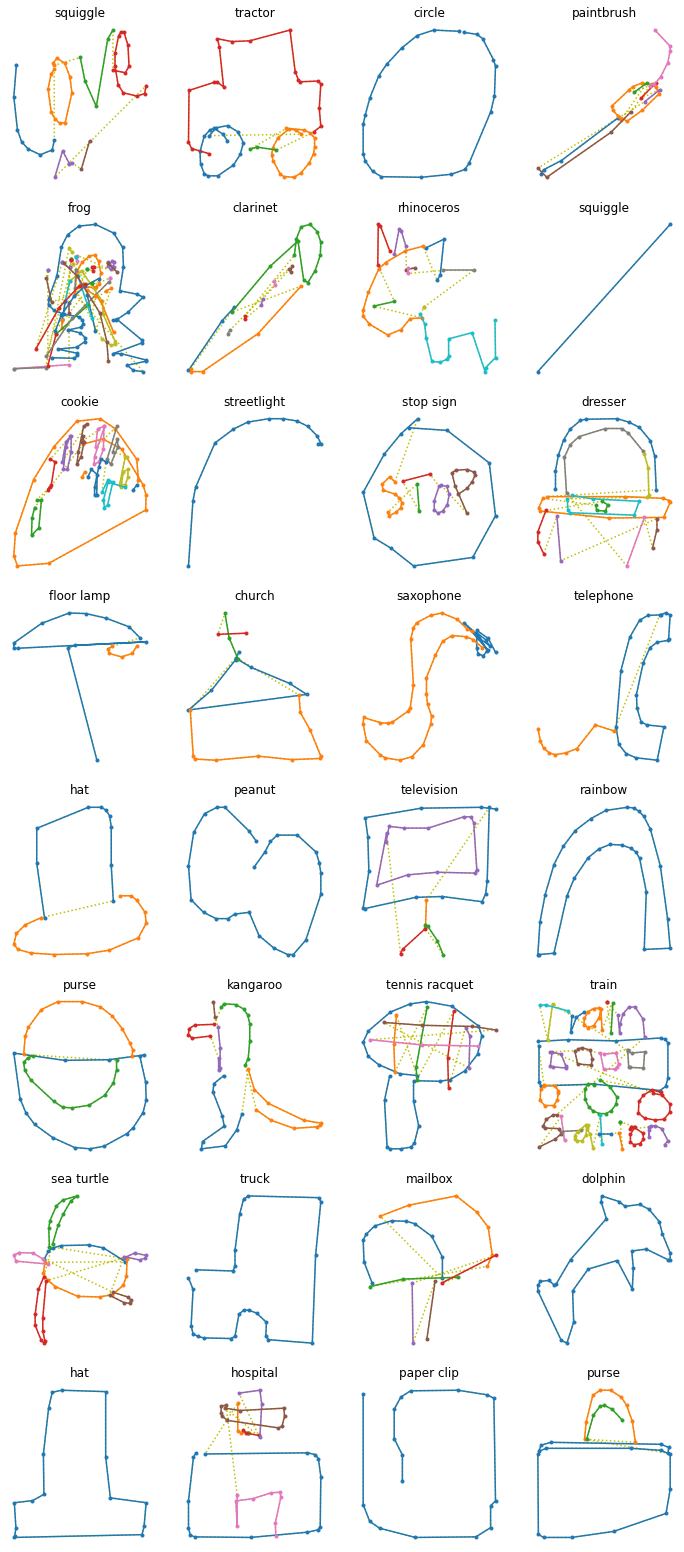

In [ ]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = np.cumsum(sketch[:, :2], axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

In [ ]:
# Most sketches are composed of less than 100 points

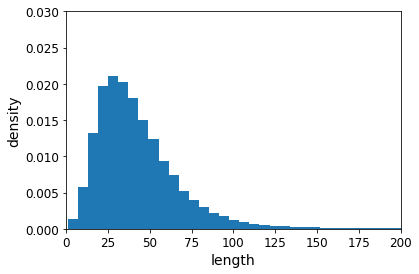

In [ ]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [ ]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set  = crop_long_sketches(test_set)

In [ ]:
# This cell takes ~1 hour to run

model = keras.models.Sequential([
    keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(len(class_names), activation="softmax")
])

optimizer = keras.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])

# history = model.fit(cropped_train_set, epochs=2, validation_data=cropped_valid_set)

In [ ]:
# 10. Download the Bach chorales dataset and unzip it. It is composed of 382 chorales composed by Johann Sebastian Bach.
# Each chorale is 100 to 640 time steps long, and each time step contains 4 integers, where each integer corresponds to a note's index on a piano
# (except for the value 0, which means that no note is played). Train a model—recurrent, convolutional, or both—that can predict the next time step (four notes),
# given a sequence of time steps from a chorale. Then use this model to generate Bach-like music, one note at a time:
# you can do this by giving the model the start of a chorale and asking it to predict the next time step,
# then appending these time steps to the input sequence and asking the model for the next note, and so on

In [ ]:
DOWNLOAD_ROOT = "https://github.com/ageron/handson-ml2/raw/master/datasets/jsb_chorales/"
FILENAME = "jsb_chorales.tgz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/jsb_chorales",
                                extract=True)

131072/117661 [=================================] - 0s 0us/step


In [ ]:
jsb_chorales_dir = Path(filepath).parent
train_files = sorted(jsb_chorales_dir.glob("train/chorale_*.csv"))
valid_files = sorted(jsb_chorales_dir.glob("valid/chorale_*.csv"))
test_files  = sorted(jsb_chorales_dir.glob("test/chorale_*.csv"))

In [ ]:
import pandas as pd

def load_chorales(filepaths):
    return [pd.read_csv(filepath).values.tolist() for filepath in filepaths]

train_chorales = load_chorales(train_files)
valid_chorales = load_chorales(valid_files)
test_chorales  = load_chorales(test_files)

In [ ]:
train_chorales[0][:10]

[[74, 70, 65, 58],
 [74, 70, 65, 58],
 [74, 70, 65, 58],
 [74, 70, 65, 58],
 [75, 70, 58, 55],
 [75, 70, 58, 55],
 [75, 70, 60, 55],
 [75, 70, 60, 55],
 [77, 69, 62, 50],
 [77, 69, 62, 50]]

In [ ]:
# Notes range from 36 (C1 = C on octave 1) to 81 (A5 = A on octave 5), plus 0 for silence

In [ ]:
notes = set()
for chorales in (train_chorales, valid_chorales, test_chorales):
    for chorale in chorales:
        for chord in chorale:
            notes |= set(chord)

n_notes = len(notes)
min_note = min(notes - {0})
max_note = max(notes)

assert min_note == 36
assert max_note == 81

In [ ]:
from IPython.display import Audio

def notes_to_frequencies(notes):
    # Frequency doubles when you go up one octave; there are 12 semi-tones
    # per octave; Note A on octave 4 is 440 Hz, and it is note number 69.
    return 2 ** ((np.array(notes) - 69) / 12) * 440

def frequencies_to_samples(frequencies, tempo, sample_rate):
    note_duration = 60 / tempo # the tempo is measured in beats per minutes
    # To reduce click sound at every beat, we round the frequencies to try to
    # get the samples close to zero at the end of each note.
    frequencies = np.round(note_duration * frequencies) / note_duration
    n_samples = int(note_duration * sample_rate)
    time = np.linspace(0, note_duration, n_samples)
    sine_waves = np.sin(2 * np.pi * frequencies.reshape(-1, 1) * time)
    # Removing all notes with frequencies ≤ 9 Hz (includes note 0 = silence)
    sine_waves *= (frequencies > 9.).reshape(-1, 1)
    return sine_waves.reshape(-1)

def chords_to_samples(chords, tempo, sample_rate):
    freqs = notes_to_frequencies(chords)
    freqs = np.r_[freqs, freqs[-1:]] # make last note a bit longer
    merged = np.mean([frequencies_to_samples(melody, tempo, sample_rate)
                     for melody in freqs.T], axis=0)
    n_fade_out_samples = sample_rate * 60 // tempo # fade out last note
    fade_out = np.linspace(1., 0., n_fade_out_samples)**2
    merged[-n_fade_out_samples:] *= fade_out
    return merged

def play_chords(chords, tempo=160, amplitude=0.1, sample_rate=44100, filepath=None):
    samples = amplitude * chords_to_samples(chords, tempo, sample_rate)
    if filepath:
        from scipy.io import wavfile
        samples = (2**15 * samples).astype(np.int16)
        wavfile.write(filepath, sample_rate, samples)
        return display(Audio(filepath))
    else:
        return display(Audio(samples, rate=sample_rate))

In [ ]:
# Now let's listen to a few chorales
for index in range(3):
    play_chords(train_chorales[index])

Output hidden; open in https://colab.research.google.com to view.

In [40]:
# In order to be able to generate new chorales, we want to train a model that can predict the next chord given all the previous chords.
# If we naively try to predict the next chord in one shot, predicting all 4 notes at once, we run the risk of getting notes that don't go very well together.
# It's much better and simpler to predict one note at a time. So we will need to preprocess every chorale, turning each chord into an arpegio
# (i.e., a sequence of notes rather than notes played simultaneuously). So each chorale will be a long sequence of notes (rather than chords),
# and we can just train a model that can predict the next note given all the previous notes. We will use a sequence-to-sequence approach,
# where we feed a window to the neural net, and it tries to predict that same window shifted one time step into the future.

# We will also shift the values so that they range from 0 to 46, where 0 represents silence, and values 1 to 46 represent notes 36 (C1) to 81 (A5).
# And we will train the model on windows of 128 notes (i.e., 32 chords).
# Since the dataset fits in memory, we could preprocess the chorales in RAM using any Python code we like,
# but I will demonstrate here how to do all the preprocessing using tf.data (there will be more details about creating windows using tf.data in the next chapter)

In [41]:
def create_target(batch):
    X = batch[:, :-1]
    Y = batch[:, 1:] # predict next note in each arpegio, at each step
    return X, Y

def preprocess(window):
    window = tf.where(window == 0, window, window - min_note + 1) # shift values
    return tf.reshape(window, [-1]) # convert to arpegio

def bach_dataset(chorales, batch_size=32, shuffle_buffer_size=None,
                 window_size=32, window_shift=16, cache=True):
    def batch_window(window):
        return window.batch(window_size + 1)

    def to_windows(chorale):
        dataset = tf.data.Dataset.from_tensor_slices(chorale)
        dataset = dataset.window(window_size + 1, window_shift, drop_remainder=True)
        return dataset.flat_map(batch_window)

    chorales = tf.ragged.constant(chorales, ragged_rank=1)
    dataset  = tf.data.Dataset.from_tensor_slices(chorales)
    dataset =  dataset.flat_map(to_windows).map(preprocess)

    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.map(create_target)
    
    return dataset.prefetch(1)

In [42]:
# Now let's create the training set, the validation set and the test set

In [43]:
train_set = bach_dataset(train_chorales, shuffle_buffer_size=1000)
valid_set = bach_dataset(valid_chorales)
test_set  = bach_dataset(test_chorales)

In [44]:
n_embedding_dims = 5

model = keras.models.Sequential([
    keras.layers.Embedding(input_dim=n_notes, output_dim=n_embedding_dims,
                           input_shape=[None]),
    keras.layers.Conv1D(32, kernel_size=2, padding="causal", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(48, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(96, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.Dense(n_notes, activation="softmax")
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 5)           235       
                                                                 
 conv1d_6 (Conv1D)           (None, None, 32)          352       
                                                                 
 batch_normalization_6 (Batc  (None, None, 32)         128       
 hNormalization)                                                 
                                                                 
 conv1d_7 (Conv1D)           (None, None, 48)          3120      
                                                                 
 batch_normalization_7 (Batc  (None, None, 48)         192       
 hNormalization)                                                 
                                                                 
 conv1d_8 (Conv1D)           (None, None, 64)         

In [45]:
optimizer = keras.optimizers.Nadam(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.fit(train_set, epochs=20, validation_data=valid_set)

Epoch 1/20
98/98 [==============================] - 124s 637ms/step - loss: 1.7822 - accuracy: 0.5502 - val_loss: 3.6845 - val_accuracy: 0.0285
Epoch 2/20
98/98 [==============================] - 66s 679ms/step - loss: 0.8761 - accuracy: 0.7696 - val_loss: 3.2231 - val_accuracy: 0.1350
Epoch 3/20
98/98 [==============================] - 66s 674ms/step - loss: 0.7454 - accuracy: 0.7937 - val_loss: 3.0117 - val_accuracy: 0.1467
Epoch 4/20
98/98 [==============================] - 71s 722ms/step - loss: 0.6726 - accuracy: 0.8078 - val_loss: 2.1054 - val_accuracy: 0.3568
Epoch 5/20
98/98 [==============================] - 59s 605ms/step - loss: 0.6184 - accuracy: 0.8194 - val_loss: 1.2790 - val_accuracy: 0.6215
Epoch 6/20
98/98 [==============================] - 69s 704ms/step - loss: 0.5770 - accuracy: 0.8292 - val_loss: 0.8814 - val_accuracy: 0.7365
Epoch 7/20
98/98 [==============================] - 57s 582ms/step - loss: 0.5392 - accuracy: 0.8383 - val_loss: 0.6882 - val_accuracy: 0.798

In [46]:
def generate_chorale(model, seed_chords, length):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])
    for chord in range(length):
        for note in range(4):
            #next_note = model.predict_classes(arpegio)[:1, -1:]
            next_note = np.argmax(model.predict(arpegio), axis=-1)[:1, -1:]
            arpegio = tf.concat([arpegio, next_note], axis=1)
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])

In [47]:
seed_chords = test_chorales[2][:8]
play_chords(seed_chords, amplitude=0.2)

In [48]:
new_chorale = generate_chorale(model, seed_chords, 56)
play_chords(new_chorale)

Output hidden; open in https://colab.research.google.com to view.

In [49]:
# This approach has one major flaw: it is often too conservative. Indeed, the model will not take any risk, it will always choose the note with the highest score,
# and since repeating the previous note generally sounds good enough, it's the least risky option, so the algorithm will tend to make notes last longer and longer.
# Pretty boring. Plus, if you run the model multiple times, it will always generate the same melody.

# So let's spice things up a bit! Instead of always picking the note with the highest score, we will pick the next note randomly, according to the predicted probabilities.
# For example, if the model predicts a C3 with 75% probability, and a G3 with a 25% probability, then we will pick one of these two notes randomly, with these probabilities.
# We will also add a temperature parameter that will control how "hot" (i.e., daring) we want the system to feel.
# A high temperature will bring the predicted probabilities closer together, reducing the probability of the likely notes and increasing the probability of the unlikely ones.

In [50]:
def generate_chorale_v2(model, seed_chords, length, temperature=1):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])
    for chord in range(length):
        for note in range(4):
            next_note_probas = model.predict(arpegio)[0, -1:]
            rescaled_logits = tf.math.log(next_note_probas) / temperature
            next_note = tf.random.categorical(rescaled_logits, num_samples=1)
            arpegio = tf.concat([arpegio, next_note], axis=1)
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])

In [51]:
new_chorale_v2_cold = generate_chorale_v2(model, seed_chords, 56, temperature=0.8)
play_chords(new_chorale_v2_cold, filepath="bach_cold.wav")

Output hidden; open in https://colab.research.google.com to view.

In [52]:
new_chorale_v2_medium = generate_chorale_v2(model, seed_chords, 56, temperature=1.0)
play_chords(new_chorale_v2_medium, filepath="bach_medium.wav")

Output hidden; open in https://colab.research.google.com to view.

In [53]:
new_chorale_v2_hot = generate_chorale_v2(model, seed_chords, 56, temperature=1.5)
play_chords(new_chorale_v2_hot, filepath="bach_hot.wav")

Output hidden; open in https://colab.research.google.com to view.

In [54]:
play_chords(test_chorales[2][:64], filepath="bach_test_4.wav")

Output hidden; open in https://colab.research.google.com to view.